# Base Model HMM

In [49]:
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm


def calculate_Zscore(df, serie):
    this_df = deepcopy(df)
    return_series = this_df[serie].pct_change()
    return return_series.mean() / (return_series.std(ddof=1) / np.sqrt(return_series.shape))

def compare_strat_perf(train):
    print('For the buy and hold trading strategy => Overall return = %0.2f%%  ~  Z-score = %0.3f' 
      % (100 * (train['Close'].iloc[-1] / train['Close'].iloc[0] - 1), calculate_Zscore(train, 'Close')))
    print('For the HMM based    trading strategy => Overall return = %0.2f%%  ~  Z-score = %0.3f' 
      % (100 * (train['trading_sim'].iloc[-1] / train['trading_sim'].iloc[0] - 1), calculate_Zscore(train, 'trading_sim')))

def graph_prediction(predictions, train, loser):
    predictions_start = np.where((predictions == loser).astype(int) * (np.pad(np.diff(predictions), (1, 0)) != 0).astype(int))[0]
    predictions_end   = np.where((predictions == loser).astype(int) * (np.pad(np.diff(predictions), (0, 1)) != 0).astype(int))[0]

    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    train.plot(x='Date', y='Close', color='dodgerblue', label='Long Only', ax=ax)
    train.plot(x='Date', y='trading_sim', color='orange', label='With HMM Regime detection', ax=ax)
    for st, end in zip(predictions_start, predictions_end):
        ax.axvspan(st, end, alpha=0.2, color='cyan')
    plt.title('Train set Trading Simulation', fontsize=26)
    plt.grid()
    plt.legend()
    plt.show()
    compare_strat_perf(train)



* first we set the global variables.

In [50]:
# Hidden Markov Model Modifiable Parameters
hidden_states = 3;
em_iterations = 100;

* then we read the data and delete the unwanted data

In [51]:
df = pd.read_csv('data/SPY.csv')

df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

* Here is our remaining DF

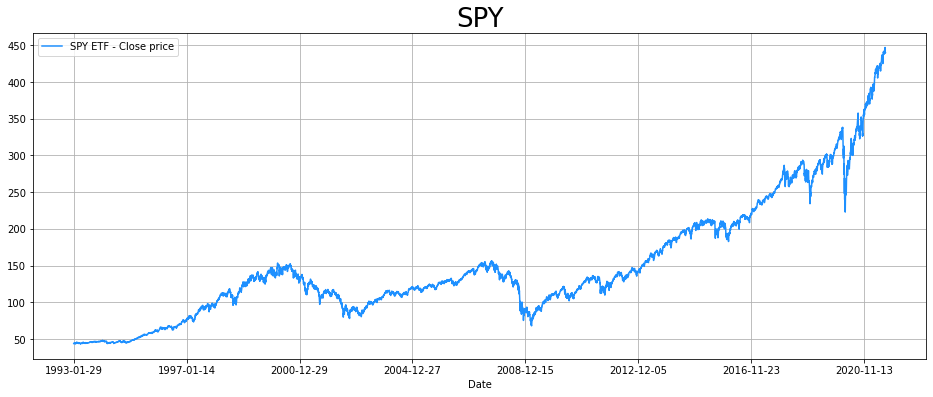

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df.plot(x='Date', y='Close', color='dodgerblue', label='SPY ETF - Close price', ax=ax)
plt.title('SPY', fontsize=26)
plt.grid()
plt.legend();

In [53]:
df

,Date,Close
0,1993-01-29,43.937500
1,1993-02-01,44.250000
2,1993-02-02,44.343750
3,1993-02-03,44.812500
4,1993-02-04,45.000000
...,...,...
7187,2021-08-13,445.920013
7188,2021-08-16,446.970001
7189,2021-08-17,444.040009
7190,2021-08-18,439.179993


* Now let's set the MA and then Volatility for some number of days, and add the daily Return of the SPY in percentage

In [54]:
yearly_adjust = np.sqrt(252)
hist_periods = [10, 30, 60, 120]
log_return = pd.Series(np.log(df['Close'] / df['Close'].shift(1)))
for period in hist_periods:
    df[f'MA_{period}_days'] = log_return.rolling(period).mean() * yearly_adjust
    df[f'hist_vol_{period}_days'] = log_return.rolling(period).std() * yearly_adjust
df['Return'] = df['Close'].pct_change() * 100
df.fillna(0,inplace=True)
df

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return
0,1993-01-29,43.937500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1993-02-01,44.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.711238
2,1993-02-02,44.343750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211864
3,1993-02-03,44.812500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.057082
4,1993-02-04,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.418410
...,...,...,...,...,...,...,...,...,...,...,...
7187,2021-08-13,445.920013,0.026601,0.060217,0.018708,0.099337,0.021665,0.093842,0.018576,0.125438,0.181984
7188,2021-08-16,446.970001,0.033668,0.056429,0.015923,0.097529,0.019456,0.091833,0.017438,0.124633,0.235466
7189,2021-08-17,444.040009,0.010366,0.060805,0.013408,0.099675,0.017933,0.093130,0.019794,0.119485,-0.655523
7190,2021-08-18,439.179993,0.000723,0.080787,0.005718,0.105031,0.012338,0.094463,0.019022,0.120444,-1.094500


* This is our final DF with all moving average and the Return values

In [55]:
# now we mark the test train randomly

# first we set a global var for year training days
year = 252

# we will set the start data 10 years + all nulls from MA
start_train_idx = 121 + 10*year

# stop for 2 years prior to data ends
stop_train_idx = df.shape[0] - 2*year

# and end index for the ending
end_test_idx = df.shape[0]

* divide the data

In [56]:
train = pd.DataFrame(df, index = range(start_train_idx, stop_train_idx)).reset_index(drop=True)
test = pd.DataFrame(df, index = range(stop_train_idx + 1, end_test_idx)).reset_index(drop=True)

* see the shapes

In [57]:
train.shape, test.shape

((4047, 11), (503, 11))

* Create the model

In [58]:
model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations, random_state=26);

* we will set the Data to be Fitted on the Historical 10 days Volatility and the return.

In [82]:
def run_hmm_model(keep_columns):
    
    # define the reduced DataFrame and train the model
    this_train = deepcopy(train)
    this_obs = this_train[keep_columns].to_numpy()
    this_model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations, random_state=26)
    this_model.fit(this_obs)
    this_predictions = this_model.predict(this_obs)
    print('\n')
    
    # Plot the regimes path and the colorful Index points
    plt.figure(figsize=(16, 6))
    plt.plot(this_predictions, 'bo')
    plt.title('Path to Regimes')
    plt.show()
    plot = sns.relplot(x=range(0,train.shape[0]), y="Close", data=train, hue=this_predictions, linewidth = 0, palette="Set1", s = 10);
    plot.fig.set_size_inches(18,10)
    plot.fig.suptitle('SPY ETF with relevant regime')
    plt.show()
    print('\n\n')
    
    # Print model score
    print("Model Score: {0}".format(this_model.score(this_obs)));
    print('\n')
    
    # Display states
    this_res_train = deepcopy(train)
    this_res_train['prediction'] = this_predictions
    this_res_total = this_res_train[[x for x in keep_columns] + ['prediction']].groupby('prediction').mean().reset_index()
    display(this_res_total)
    
    this_loser_state = this_res_total['Return'].argmin()
    this_winner_state = this_res_total['Return'].argmax()
    this_loser_state, this_winner_state
    print(f'The Winner State is: {this_winner_state} / The Loser State is: {this_loser_state}')
    
    # Display states and simulate Trading
    this_first_trading = train['Close'].iloc[0]
    this_trading = [this_first_trading]
    for day, (daily_return, prediction) in enumerate(zip(train['Return'][1:], this_predictions[1:]), start=1):
        this_trading.append(this_trading[-1] * (1 + (daily_return / 100 * (prediction != this_loser_state))))
    this_train['trading_sim'] = this_trading
    display(this_train)
    
    # Graph Predictions on TRAIN SET
    graph_prediction(this_predictions, this_train, this_loser_state)
    
    # Define TEST SET and generate predictions
    this_test = deepcopy(test)
    this_obs_test = this_test[keep_columns].to_numpy()
    this_predictions_list = []
    this_predictions_list_all = []
    for i, index in enumerate(this_obs_test):
        this_predict = this_model.predict(np.vstack((this_obs, this_obs_test[:i])))
        this_predictions_list.append(this_predict[-1])
        this_predictions_list_all.append(this_predict.tolist() + [this_predict[-1]] * (len(this_obs_test) - i))
        
    # Display states and simulate Trading
    this_first_trading_test = test['Close'].iloc[0]
    this_trading_test = [this_first_trading_test]
    this_predictions_test = np.array(this_predictions_list)
    for day, (daily_return, prediction) in enumerate(zip(test['Return'][1:], this_predictions_test[1:]), start=1):
        this_trading_test.append(this_trading_test[-1] * (1 + (daily_return / 100 * (prediction != this_loser_state) * (1 + 0 * (prediction == this_winner_state)))))
    this_test['trading_sim'] = this_trading_test

    graph_prediction(this_predictions_list, this_test, this_loser_state)

In [83]:
columns_to_remove = ['Date', 'Close']
columns_to_keep = [x for x in train.columns if x not in columns_to_remove]

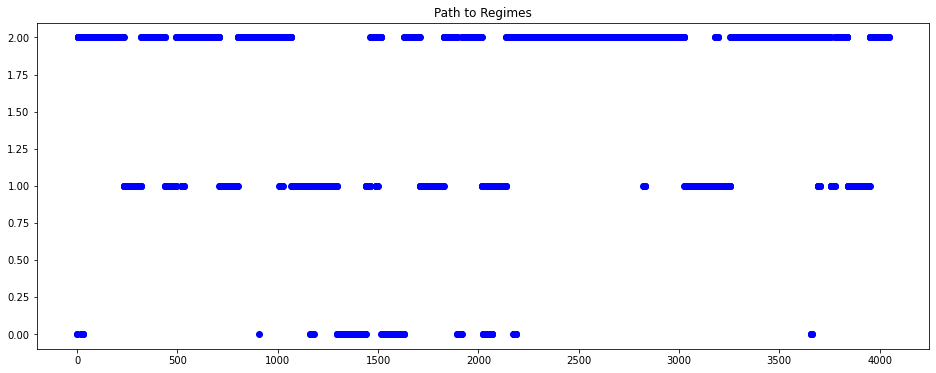

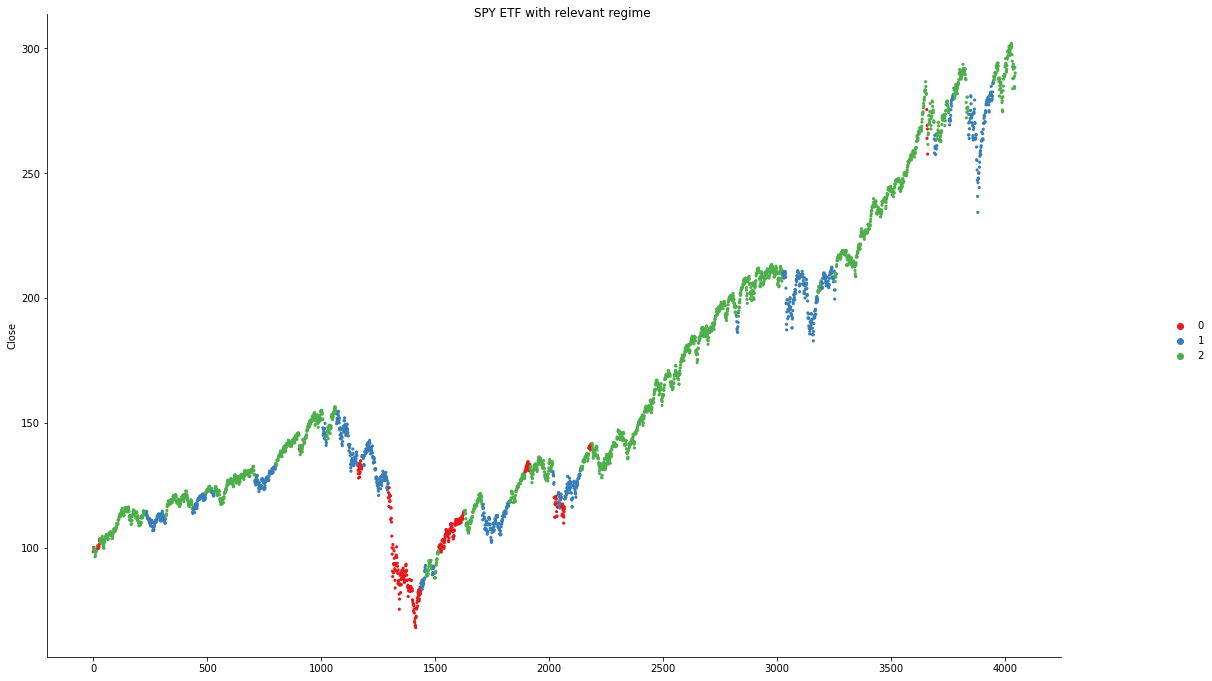




Model Score: 9268.490713801106




,prediction,Return,MA_120_days
0,0,-0.050933,-0.009469
1,1,-0.009048,-0.004106
2,2,0.062037,0.010034


The Winner State is: 2 / The Loser State is: 0


,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2003-07-24,98.489998,-0.013002,0.144743,-0.009636,0.162325,0.017719,0.155028,0.017847,0.187889,-0.755744,98.489998
1,2003-07-25,100.230003,-0.000158,0.165046,-0.002002,0.170363,0.022927,0.158456,0.019903,0.189382,1.766682,98.489998
2,2003-07-28,99.860001,-0.013770,0.163544,0.001592,0.167892,0.021978,0.158777,0.020724,0.188820,-0.369153,98.126419
3,2003-07-29,99.400002,-0.017629,0.164545,-0.011896,0.156343,0.017011,0.156979,0.020937,0.188698,-0.460644,97.674406
4,2003-07-30,99.160004,-0.012120,0.162636,-0.013175,0.156399,0.016883,0.157021,0.021242,0.188571,-0.241447,97.438574
...,...,...,...,...,...,...,...,...,...,...,...,...
4042,2019-08-14,283.899994,-0.073907,0.277827,-0.022853,0.172750,-0.000047,0.149935,0.002237,0.131500,-2.956758,380.811999
4043,2019-08-15,284.649994,-0.055835,0.279009,-0.025671,0.170911,-0.001723,0.148873,0.002406,0.131538,0.264178,381.818019
4044,2019-08-16,288.850006,-0.020585,0.291971,-0.017318,0.177300,0.002966,0.151767,0.004438,0.133197,1.475500,387.451745
4045,2019-08-19,292.329987,0.046898,0.247353,-0.008066,0.180722,0.009387,0.151392,0.006079,0.134266,1.204771,392.119652


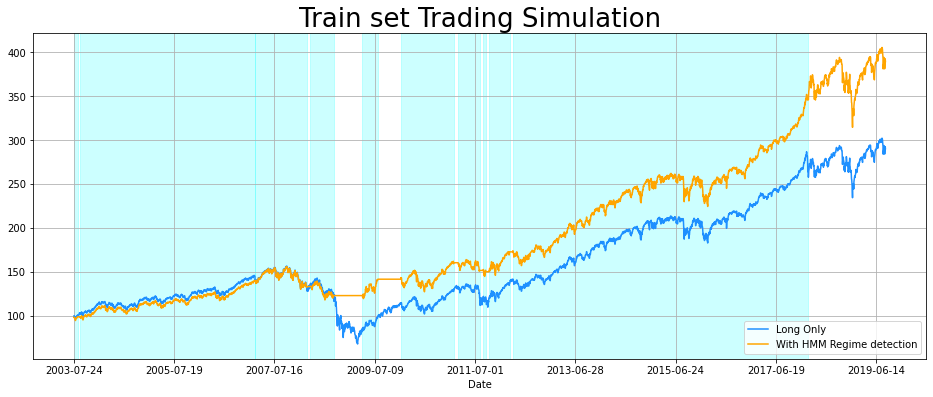

For the buy and hold trading strategy => Overall return = 194.54%  ~  Z-score = 1.859
For the HMM based    trading strategy => Overall return = 295.08%  ~  Z-score = 2.848


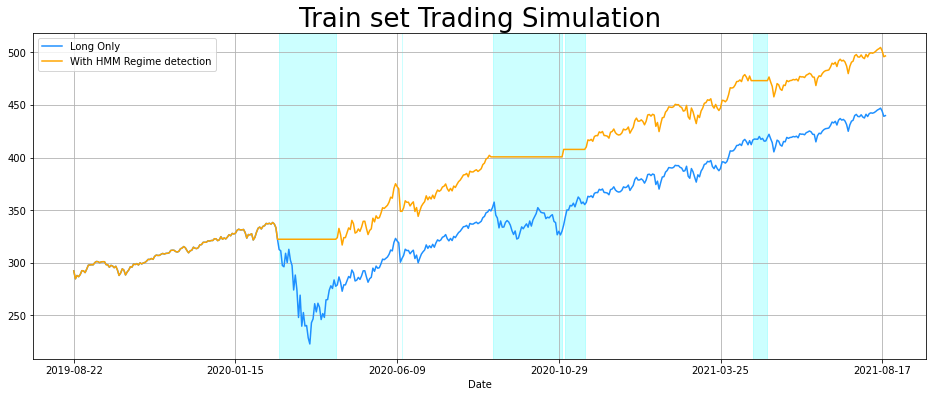

For the buy and hold trading strategy => Overall return = 50.45%  ~  Z-score = 1.328
For the HMM based    trading strategy => Overall return = 69.85%  ~  Z-score = 2.941


In [94]:
run_hmm_model(["Return", 'MA_120_days'])

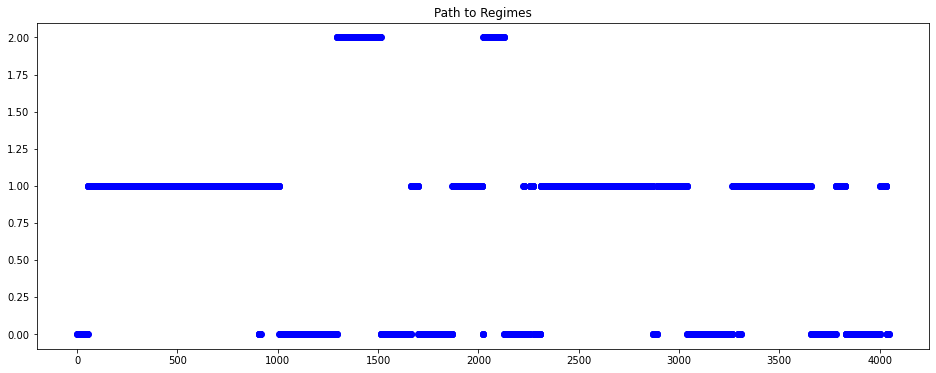

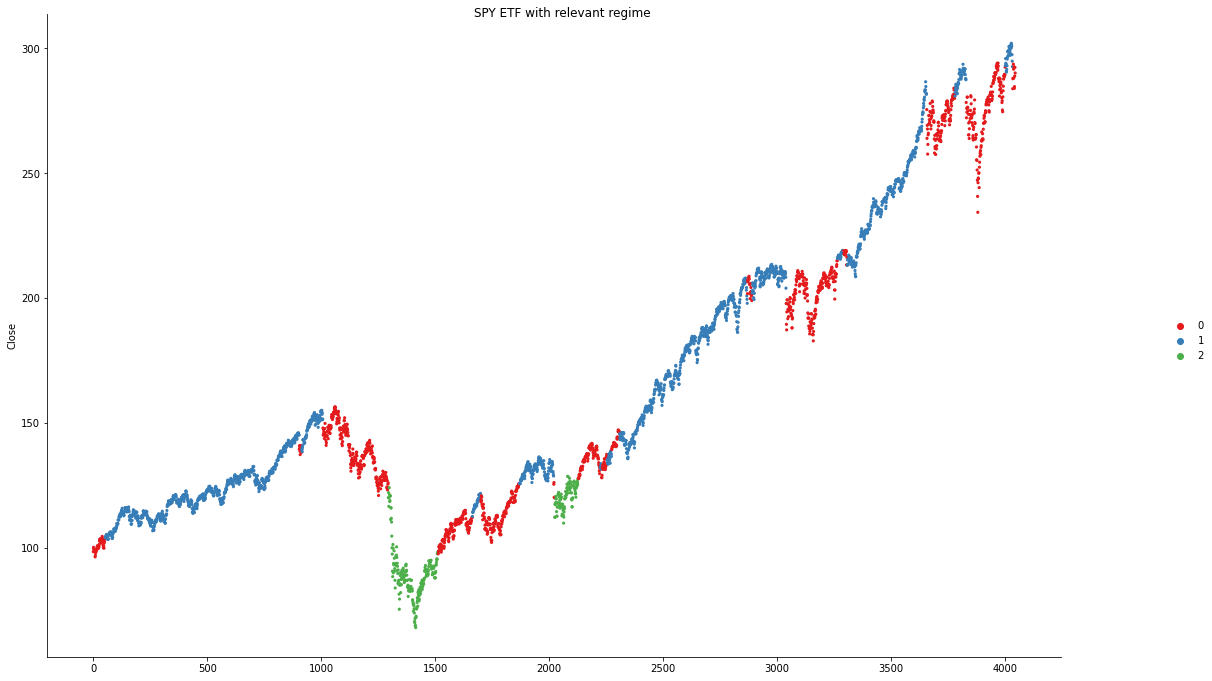




Model Score: 77703.1539787673




,prediction,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return
0,0,0.000280,0.165456,0.001724,0.167353,0.003025,0.171416,0.004168,0.178387,0.013701
1,1,0.009085,0.099181,0.008967,0.104247,0.008272,0.106221,0.008807,0.109768,0.052151
2,2,-0.014135,0.394451,-0.018657,0.401953,-0.018599,0.407158,-0.024945,0.397643,-0.022027


The Winner State is: 1 / The Loser State is: 2


,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2003-07-24,98.489998,-0.013002,0.144743,-0.009636,0.162325,0.017719,0.155028,0.017847,0.187889,-0.755744,98.489998
1,2003-07-25,100.230003,-0.000158,0.165046,-0.002002,0.170363,0.022927,0.158456,0.019903,0.189382,1.766682,100.230003
2,2003-07-28,99.860001,-0.013770,0.163544,0.001592,0.167892,0.021978,0.158777,0.020724,0.188820,-0.369153,99.860001
3,2003-07-29,99.400002,-0.017629,0.164545,-0.011896,0.156343,0.017011,0.156979,0.020937,0.188698,-0.460644,99.400002
4,2003-07-30,99.160004,-0.012120,0.162636,-0.013175,0.156399,0.016883,0.157021,0.021242,0.188571,-0.241447,99.160004
...,...,...,...,...,...,...,...,...,...,...,...,...
4042,2019-08-14,283.899994,-0.073907,0.277827,-0.022853,0.172750,-0.000047,0.149935,0.002237,0.131500,-2.956758,343.864617
4043,2019-08-15,284.649994,-0.055835,0.279009,-0.025671,0.170911,-0.001723,0.148873,0.002406,0.131538,0.264178,344.773030
4044,2019-08-16,288.850006,-0.020585,0.291971,-0.017318,0.177300,0.002966,0.151767,0.004438,0.133197,1.475500,349.860157
4045,2019-08-19,292.329987,0.046898,0.247353,-0.008066,0.180722,0.009387,0.151392,0.006079,0.134266,1.204771,354.075171


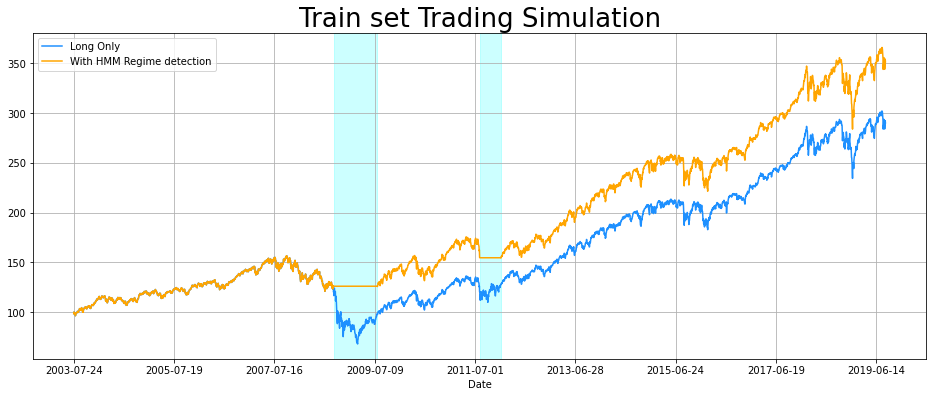

For the buy and hold trading strategy => Overall return = 194.54%  ~  Z-score = 1.859
For the HMM based    trading strategy => Overall return = 256.75%  ~  Z-score = 2.676


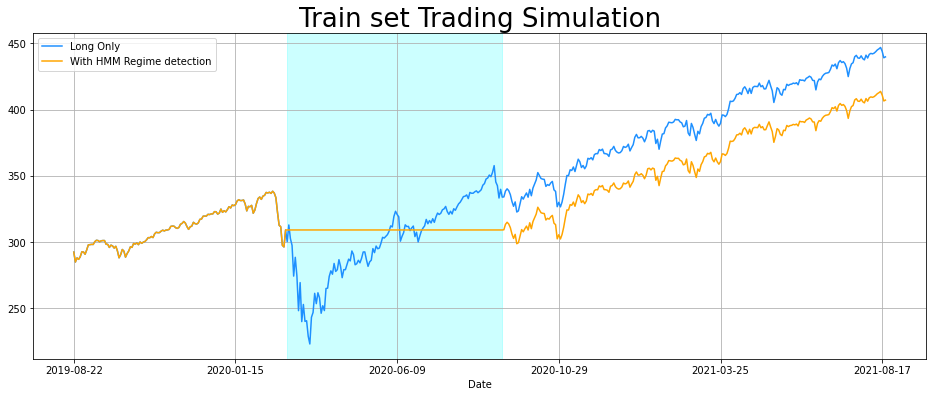

For the buy and hold trading strategy => Overall return = 50.45%  ~  Z-score = 1.328
For the HMM based    trading strategy => Overall return = 39.28%  ~  Z-score = 1.978


In [79]:
run_hmm_model(columns_to_keep)

In [14]:
train[columns_to_keep]

,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return
0,-0.013002,0.144743,-0.009636,0.162325,0.017719,0.155028,0.017847,0.187889,-0.755744
1,-0.000158,0.165046,-0.002002,0.170363,0.022927,0.158456,0.019903,0.189382,1.766682
2,-0.013770,0.163544,0.001592,0.167892,0.021978,0.158777,0.020724,0.188820,-0.369153
3,-0.017629,0.164545,-0.011896,0.156343,0.017011,0.156979,0.020937,0.188698,-0.460644
4,-0.012120,0.162636,-0.013175,0.156399,0.016883,0.157021,0.021242,0.188571,-0.241447
...,...,...,...,...,...,...,...,...,...
4042,-0.073907,0.277827,-0.022853,0.172750,-0.000047,0.149935,0.002237,0.131500,-2.956758
4043,-0.055835,0.279009,-0.025671,0.170911,-0.001723,0.148873,0.002406,0.131538,0.264178
4044,-0.020585,0.291971,-0.017318,0.177300,0.002966,0.151767,0.004438,0.133197,1.475500
4045,0.046898,0.247353,-0.008066,0.180722,0.009387,0.151392,0.006079,0.134266,1.204771


In [15]:
obs = train[columns_to_keep].to_numpy()

* Fitting the model and obtaining predictions

In [16]:
model.fit(obs)
predictions = model.predict(obs)

* now we see the predictions

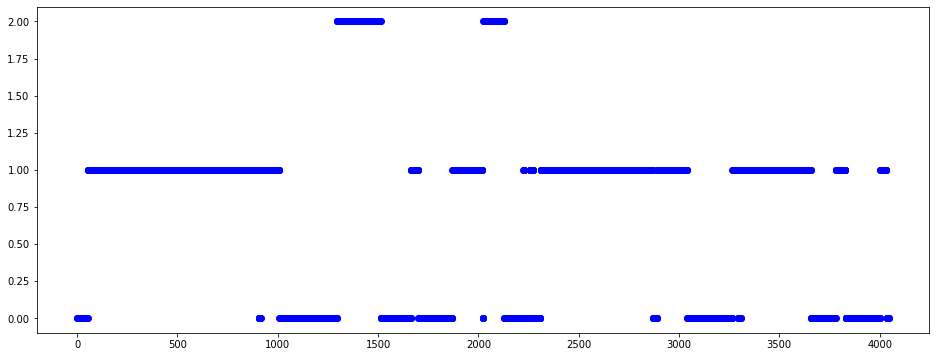

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(predictions, 'bo');

* and lets plot the state with regards to the closing 

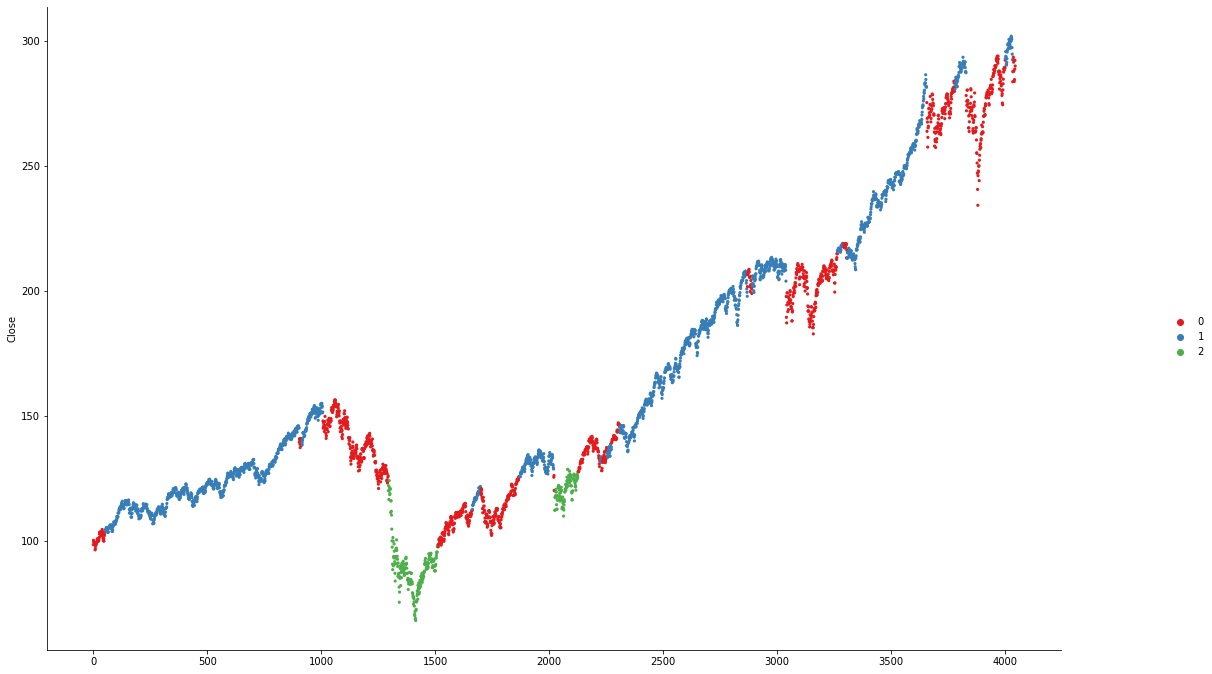

In [18]:
plot = sns.relplot(x=range(0,train.shape[0]), y="Close", data=train, hue=predictions, linewidth = 0, palette="Set1", s = 10);
plot.fig.set_size_inches(18,10)

In [19]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: 77703.15397876599


In [20]:
res_train = deepcopy(train)
res_train['prediction'] = predictions
res_total = res_train[[x for x in columns_to_keep] + ['prediction']].groupby('prediction').mean().reset_index()
res_total

,prediction,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return
0,0,0.000280,0.165456,0.001724,0.167353,0.003025,0.171416,0.004168,0.178387,0.013701
1,1,0.009085,0.099181,0.008967,0.104247,0.008272,0.106221,0.008807,0.109768,0.052151
2,2,-0.014135,0.394451,-0.018657,0.401953,-0.018599,0.407158,-0.024945,0.397643,-0.022027


In [21]:
loser_state = res_total['Return'].argmin()
winner_state = res_total['Return'].argmax()
loser_state, winner_state

(2, 1)

* we can see 1 is the "loser state" (it changes for each iteration...) we will choose the other states 

In [22]:
first_trading = train['Close'].iloc[0]
trading = [first_trading]
for day, (daily_return, prediction) in enumerate(zip(train['Return'][1:], predictions[1:]), start=1):
    trading.append(trading[-1] * (1 + (daily_return / 100 * (prediction != loser_state))))
train['trading_sim'] = trading
train

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2003-07-24,98.489998,-0.013002,0.144743,-0.009636,0.162325,0.017719,0.155028,0.017847,0.187889,-0.755744,98.489998
1,2003-07-25,100.230003,-0.000158,0.165046,-0.002002,0.170363,0.022927,0.158456,0.019903,0.189382,1.766682,100.230003
2,2003-07-28,99.860001,-0.013770,0.163544,0.001592,0.167892,0.021978,0.158777,0.020724,0.188820,-0.369153,99.860001
3,2003-07-29,99.400002,-0.017629,0.164545,-0.011896,0.156343,0.017011,0.156979,0.020937,0.188698,-0.460644,99.400002
4,2003-07-30,99.160004,-0.012120,0.162636,-0.013175,0.156399,0.016883,0.157021,0.021242,0.188571,-0.241447,99.160004
...,...,...,...,...,...,...,...,...,...,...,...,...
4042,2019-08-14,283.899994,-0.073907,0.277827,-0.022853,0.172750,-0.000047,0.149935,0.002237,0.131500,-2.956758,343.864617
4043,2019-08-15,284.649994,-0.055835,0.279009,-0.025671,0.170911,-0.001723,0.148873,0.002406,0.131538,0.264178,344.773030
4044,2019-08-16,288.850006,-0.020585,0.291971,-0.017318,0.177300,0.002966,0.151767,0.004438,0.133197,1.475500,349.860157
4045,2019-08-19,292.329987,0.046898,0.247353,-0.008066,0.180722,0.009387,0.151392,0.006079,0.134266,1.204771,354.075171


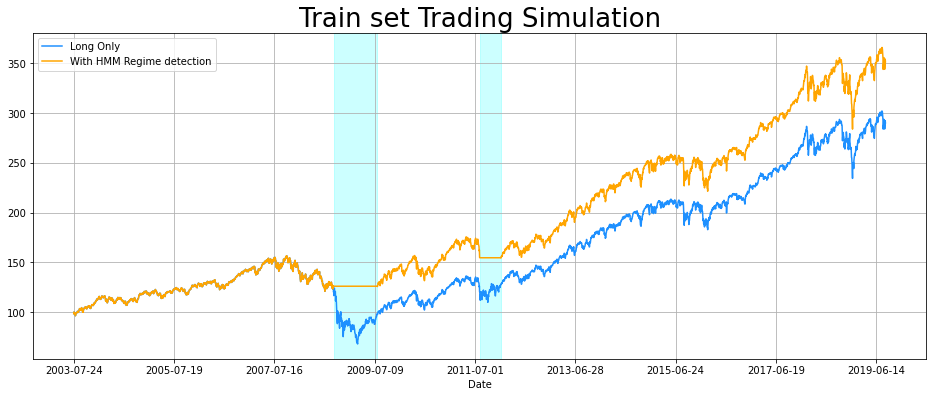

For the buy and hold trading strategy => Overall return = 194.54%  ~  Z-score = 1.859
For the HMM based    trading strategy => Overall return = 256.75%  ~  Z-score = 2.676


In [24]:
graph_prediction(predictions, train, loser_state)

We see that our model managed to detect some periods of bear market, and overall it has a significantly better return than the Long-Only model!<br>
It has also a Z-score almost twice as good, which means it seems valuable!

# Now let's test the model on the test data !

In [ ]:
obs_test = test[columns_to_keep].to_numpy()
obs_test

In [ ]:
predictions_future_leak = model.predict(obs_test)
plt.figure(figsize=(16, 6))
plt.plot(predictions_future_leak, 'bo');

In [ ]:
predictions_future_leak.shape

In [ ]:
model.predict(obs).shape

In [ ]:
len(obs)

In [ ]:
len(obs_test)

In [ ]:
(obs + obs_test[:i]) if i > 0 else obs

In [ ]:
predictions_list = []
predictions_list_all = []
for i, index in enumerate(obs_test):
    this_predict = model.predict(np.vstack((obs, obs_test[:i])))
    predictions_list.append(this_predict[-1])
    predictions_list_all.append(this_predict.tolist() + [this_predict[-1]] * (len(obs_test) - i))

In [ ]:
len(predictions_list_all)

In [ ]:
nb_lines, sanity_check, nb_cols = len(predictions_list_all[0]), len(predictions_list_all[-1]), len(predictions_list_all)
nb_lines, sanity_check, nb_cols

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.array(predictions_list_all), cmap="BuPu");

We would like to check if there was any change in the "predict" of the model on the train set. Let's have a look!

In [ ]:
pred_df = pd.DataFrame(np.array(predictions_list_all).T)
set(pred_df.iloc[:4047, :].sum(axis='columns') % 503)

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.array(predictions_list_all)[:, :4047], cmap="BuPu");

We can see that there was no change at all. The way we checked it is as follows: For each point in the observation_test we run a "predict" on the whole series of data, including the initial train set (obs) and an increasing number of points from the test set. Then we stack all these predictions, just keeping the last point and copying it to the end (to have the same number of points for all the predictions). Eventually, I draw a heatmap of all the predictions, to see if all the points predicted for the train and test sets are predicted the same.<br>
Moreover, on the train set we sum all the columns numbers and compute modulo 503 (the number of test points) to check if there were some different predictions in the train set for different numbers of added test points. And we got 0 ! Meaning for all the steps of the test set prediction, we had 503 times the exact same Hidden State prediction for each point of the train set!

Let's have a closer look at the test set now.

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.array(predictions_list_all)[:, 4047:], cmap="BuPu");

This looks like psychedelic... But we can see here that there are at least 2 times for which the prediction for the point t will eventually be overriden later when further points will be available... <br>
Let's have a look at the numbers.

In [ ]:
test_predict = np.array(predictions_list_all)[:, -503:]
test_predict.shape

In [ ]:
for i in range(test_predict.shape[0] - 1):
    if len(set(test_predict[i+1:, i].tolist())) > 1:
        print(f'There is a prediction override for the test point {i} !!')

In [ ]:
test_predict[482:, 482:]

In [ ]:
results_df = pd.DataFrame({'pred_future_leak': predictions_future_leak, 'pred_valid': predictions_list})
results_df['difference'] = 1 * np.not_equal(results_df['pred_future_leak'], results_df['pred_valid'])
results_df

In [ ]:
predictions_list

In [ ]:
obs_test = list(zip(test["hist_vol_10_days"], test["Return"]))
predictions_test = np.array(predictions_list)
plt.figure(figsize=(16, 6))
plt.plot(predictions_test, 'bo');

In [ ]:
plot = sns.relplot(x=range(0,test.shape[0]), y="Close", data=test, hue=predictions_test, linewidth = 0, palette="Set1", s = 10);
plot.fig.set_size_inches(18,10)


In [ ]:
print("Model Score: {0}".format(model.score(obs)));

In [ ]:
first_trading_test = test['Close'].iloc[0]
trading_test = [first_trading_test]
for day, (daily_return, prediction) in enumerate(zip(test['Return'][1:], predictions_test[1:]), start=1):
    trading_test.append(trading_test[-1] * (1 + (daily_return / 100 * (prediction != loser_state))))
test['trading_sim_test'] = trading_test
test

* we can see a great outcome for about 30 $

In [ ]:
first_trading_test = test['Close'].iloc[0]
trading_test = [first_trading_test]
for day, (daily_return, prediction) in enumerate(zip(test['Return'][1:], predictions_test[1:]), start=1):
    trading_test.append(trading_test[-1] * (1 + (daily_return / 100 * (prediction != loser_state) * (1 + 0 * (prediction == winner_state)))))
test['trading_sim_test'] = trading_test
test

In [ ]:
#[(st, end) for (st, end) in zip(predictions_test_start, predictions_test_end)]

In [ ]:
predictions_test_start = np.where((predictions_test == 1).astype(int) * (np.pad(np.diff(predictions_test), (1, 0)) != 0).astype(int))[0]
predictions_test_end   = np.where((predictions_test == 1).astype(int) * (np.pad(np.diff(predictions_test), (0, 1)) != 0).astype(int))[0]

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
test.plot(x='Date', y='Close', color='dodgerblue', label='Long Only', ax=ax)
test.plot(x='Date', y='trading_sim_test', color='orange', label='With HMM Regime detection', ax=ax)
for st, end in zip(predictions_test_start, predictions_test_end):
    ax.axvspan(st, end, alpha=0.2, color='cyan')
plt.title('Test set Trading Simulation', fontsize=26)
plt.grid()
plt.legend();

In [ ]:
print('For the buy and hold trading strategy => Overall return = %0.2f%%  ~  Z-score = %0.3f' 
      % (100 * (test['Close'].iloc[-1] / test['Close'].iloc[0] - 1), calculate_Zscore(test, 'Close')))
print('For the HMM based    trading strategy => Overall return = %0.2f%%  ~  Z-score = %0.3f' 
      % (100 * (test['trading_sim_test'].iloc[-1] / test['trading_sim_test'].iloc[0] - 1), calculate_Zscore(test, 'trading_sim_test')))

In [ ]:
plt.plot([x[0] for x in obs])

In [ ]:
obs

In [ ]:
from statsmodels.tsa.stattools import adfuller
print('For the original Time Series:')
result0 = adfuller([x[1] for x in obs])
print('ADF Statistic: %f' % result0[0])
print('p-value: %f' % result0[1])

In [ ]:
import statsmodels.api as sm

fig, ax = plt.subplots(1, 2, figsize=(16,5))
sm.graphics.tsa.plot_acf( np.diff([x[1] for x in obs])[1:].squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(np.diff([x[1] for x in obs])[1:].squeeze(), lags=40, ax=ax[1])
plt.show()

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
obs

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

history = [x[1] for x in obs]
test_data = [x[1] for x in obs_test]
predictions = []
for t in tqdm(range(len(test_data))):
    model_a = ARIMA(history, order=(12,0,0))
    model_fit = model_a.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    my_obs = test_data[t]
    history.append(my_obs)
    print('predicted=%f, expected=%f' % (yhat, my_obs))

arima_3_0_rmse = mean_squared_error(test_data, predictions, squared=False)
print('Test RMSE: %.3f' % arima_3_0_rmse)

In [ ]:
from sklearn.metrics import mean_squared_error

arima_3_0_rmse = mean_squared_error(test_data, predictions, squared=False)
print('Test RMSE: %.3f' % arima_3_0_rmse)